In [1]:
import pandas as pd
import os
#xl_file = pd.ExcelFile('StatePoll2016-09-22.xlsx')
#xl_file = pd.ExcelFile('StatePoll2016-10-04.xlsx')
xl_file = pd.ExcelFile('StatePoll2016-10-15.xlsx')

df = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}


def covariance_intersection(sample,A,B):
    #A is the first candidate
    #B is the second candidate
    #sample is the samplesize
    Af=0
    Bf=0
    Samplef=0
    for i in range(0,len(A)):
        Af=Af+A[i]*sample[i]/len(A)
        Bf=Bf+B[i]*sample[i]/len(A)
        Samplef=Samplef+sample[i]/len(A)
    Af=Af/Samplef
    Bf=Bf/Samplef    
    return list((Samplef,Af,Bf))


#define the function of interest for Bayesian inference
def g(theta):
    #x is a numpy vector
    return (theta[:,0]-theta[:,1])

#function that computes the posterior sampels
def compute_posterior_samples(ap,Np):
    #ap: posterior Dirichlet distribution vector parameters
    #Np: number of MC samples
    return np.random.dirichlet(ap,Np) #we use numpy

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#number of MC samples
Np=10000
#pseudo-votes for Near-Ignorance Priors
c=2

df_res = pd.DataFrame(index=np.arange(0, 51),columns=('LowerProbability', 'UpperProbability'))
Statesind=0
for key, value in sorted(df.items()):
    Statesind=Statesind+1
    #compute the list of fused polls
    fus=covariance_intersection(df[key]['Sample'].values,df[key]['Clinton'].values/100,df[key]['Trump'].values/100)
    #data from the poll
    datapoll=np.array([fus[0]*fus[1],fus[0]*fus[2],fus[0]*(1-fus[1]-fus[2])])
    #prior for a swing scenario in favor of Clinton
    au=np.array([c,-c,0])
    #prior for a swing scenario in favor of Trump
    al=np.array([-c,c,0])

    #compute the lower and upepr distirbutions for the two swing scenarios
    postsampleslower = compute_posterior_samples(datapoll+al,Np)
    postsamplesupper = compute_posterior_samples(datapoll+au,Np)
    #Compute the lower and upepr probabilities
    problower=sum(g(postsampleslower)>0)/Np
    probupper=sum(g(postsamplesupper)>0)/Np
    df_res.loc[Statesind-1] =[problower,probupper]
    
    # Plot the figs and save to temp files
    sns.distplot(g(postsampleslower), axlabel="Clinton-Trump", 
                 kde=True, hist=True,color='darkred') #, hist_kws={"range": [-1,1]}
    go=sns.distplot(g(postsamplesupper), 
                 kde=True, hist=True,color='darkblue') #, hist_kws={"range": [-1,1
    
    go.set_title(key+'    ['+str(problower)+','+str(probupper)+']')
    plt.axvline(x=0.,color='g')
    namefile='./plots/f'+str(Statesind)+'.png'
    plt.savefig(namefile); 
    plt.close();
    
df_res.to_csv('LowerUpper.csv')


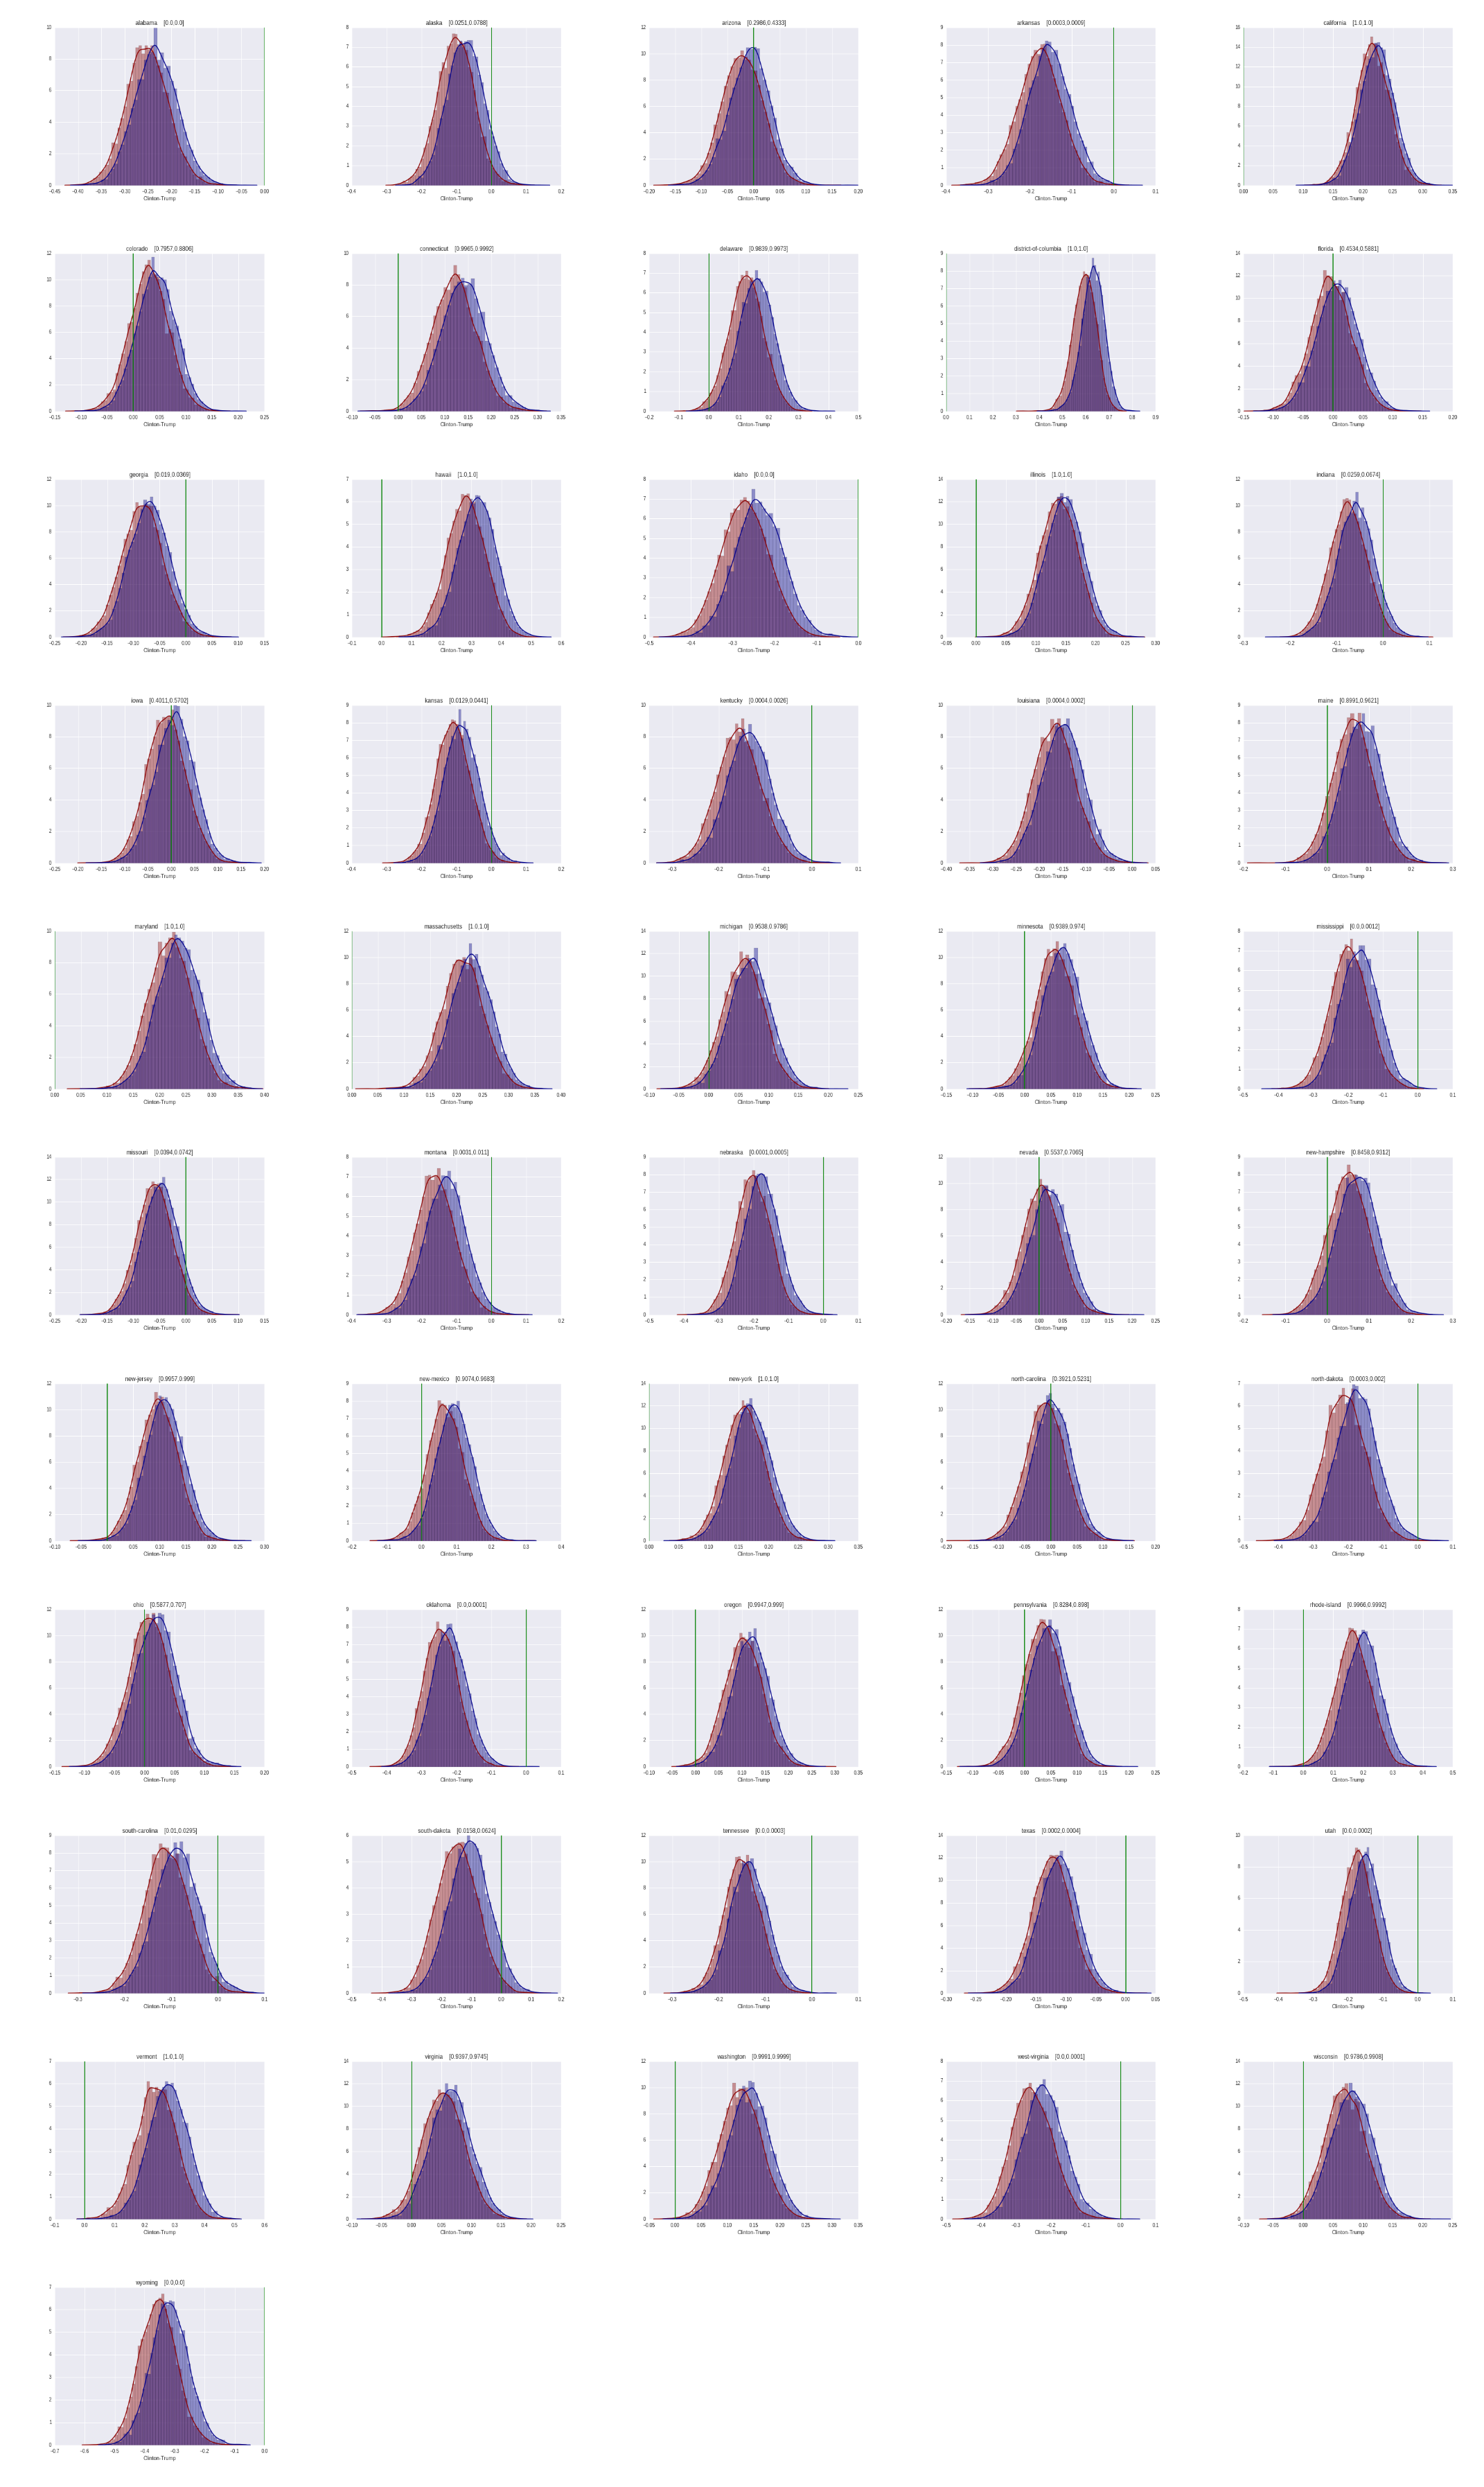

In [2]:
# Combine them with imshows
fig, ax = plt.subplots(11,5, figsize=(30,50))
count=0
for i1 in range(0,11):
    for i2 in range(0,5):
        count=count+1
        if count>51:
            ax[i1,i2].set_visible(False)
        else:
            ax[i1,i2].imshow(plt.imread('./plots/f%s.png' %count), aspect='auto'); ax[i1,i2].axis('off')
            plt.tight_layout()
            
plt.savefig('AllStates')
plt.show()


In [3]:
import pandas as pd
lowerupper     = pd.read_csv('LowerUpper.csv')
electoralvotes = pd.read_csv('electoralvotes.csv')

import numpy as np
#break-even line
evenline=269
#monte Carlo samples
Np=50000

lowvotes=0
upvotes=0
LowElec=np.zeros(Np)
UpElec=np.zeros(Np)
for i in range(0,Np):
    lowElec=0
    upElec=0
    for s in range(0,51):
        if np.random.rand(1)<lowerupper['LowerProbability'][s]:
            lowElec=lowElec+electoralvotes['Vote'][s]
        if np.random.rand(1)<lowerupper['UpperProbability'][s]:
            upElec=upElec+electoralvotes['Vote'][s]
    LowElec[i]=lowElec
    UpElec[i]=upElec
    if lowElec>evenline:
        lowvotes=lowvotes+1
    if upElec>evenline:
        upvotes=upvotes+1
    
upvotes=upvotes/Np
lowvotes=lowvotes/Np
print('['+str(lowvotes) +',' +str(upvotes)+']')

[0.93756,0.99212]


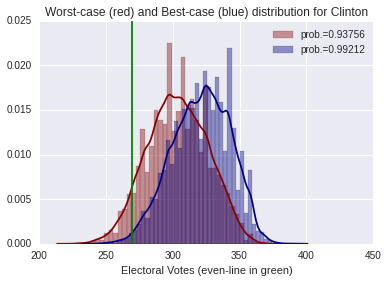

In [4]:
import warnings
import datetime as datetime
warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(LowElec, axlabel="Electoral Votes (even-line in green)", 
                 kde=True, hist=True,color='darkred',label='prob.='+str(lowvotes)) 
go=sns.distplot(UpElec, 
                 kde=True, hist=True,color='darkblue',label='prob.='+str(upvotes)) 

go.set_title('Worst-case (red) and Best-case (blue) distribution for Clinton')
go.legend()
plt.axvline(x=270.,color='g')
#plt.xlim(200,450)
plt.savefig('General' + str(datetime.date.today())+'.png')